# Notebook for CMS GIWAXS analysis via PyHyperScattering

In [ ]:
### Kernel updates:

# !pip install pyhyperscattering  # to use pip published package
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

## Restart Kernel! Next, imports & defining paths

In [1]:
## The autoreload IPython magic command reloads all modules before code is ran
%load_ext autoreload

In [ ]:
%autoreload
# phs.load.CMSGIWAXSLoader??
# phs.util.GIWAXS??

In [39]:
### Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering as phs
from PIL import Image  # Using this to load TIFFs as that is what is done in SST1RSoXSLoader.py, instead of fabio

import pyFAI
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
import pygix

print(f'Using PyHyperScattering Version: {phs.__version__}')
print(f"Using pyFAI version {pyFAI.version}")

cmap = plt.cm.turbo
cmap.set_bad('black')

pg_convewrt = phs.util.GIWAXS.pg_convert
pg_convert_series = phs.util.GIWAXS.pg_convert_series

Using PyHyperScattering Version: 0+untagged.486.g84d19b8
Using pyFAI version 2023.5.0


In [3]:
### Define paths:
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')
dataPath = propPath.joinpath('KWhite5')
calibPath = dataPath.joinpath('maxs/raw/LaB6_5.6m_12.7keV_4250.1s_x0.001_th0.120_10.00s_1118442_maxs.tiff')
maskPath = userPath.joinpath('giwaxs_suite/beamline_data/masks')
savePath = propPath.joinpath('processed_data')

In [ ]:
sorted([f.name for f in dataPath.iterdir()])

## Load selected samples & files

In [4]:
sample = 'pybtz_CB_15_200_40_60_60_011'
samplePath = dataPath.joinpath(sample, 'maxs/raw')
sorted([f.name for f in samplePath.glob('*')])

['pybtz_CB_15_200_40_60_60_011_1055.8s_x-0.000_th0.120_2.00s_1117892_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000000_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000001_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000002_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000003_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000004_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000005_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000006_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000007_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000008_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000009_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_

In [ ]:
# file = 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000097_maxs.tiff'
# # len(file.split('_'))

In [5]:
### Metadata filename naming schemes:
# For nonrotated, qpara images:
standard_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For rotated, qperp images:
qperp_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'in-plane_orientation',
                    'time_start', 'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For in situ series images:
in_situ_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 
                    'series_number', 'detector']

In [6]:
loader = phs.load.CMSGIWAXSLoader()  # empty md naming scheme
standard_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=standard_md_naming_scheme)
qperp_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=qperp_md_naming_scheme)
series_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=in_situ_md_naming_scheme)

In [7]:
pybtz_CB_0to10s_series = series_loader.loadSeries(samplePath, '1117893')
pybtz_CB_0to10s_series

<xarray.DataArray (time: 100, pix_y: 1043, pix_x: 981)>
array([[[ 1,  2,  1, ...,  1,  1,  1],
        [ 1,  2,  3, ...,  1,  2,  0],
        [ 2,  1,  1, ...,  1,  2,  1],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  1, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]],

       [[ 0,  1,  1, ...,  3,  1,  0],
        [ 1,  2,  2, ...,  0,  2,  1],
        [ 1,  1,  0, ...,  1,  3,  1],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 1,  0,  0, ..., -2, -2, -2]],

       [[ 0,  0,  1, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  0,  2,  1],
        [ 1,  0,  1, ...,  0,  0,  1],
        ...,
...
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  1, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]],

       [[ 1,  0,  0, ...,  1,  1,  1],
        [ 2,  1,  2, ...,  3,  2,  3],
        [ 0,  3,  1, ...,  6,  2,  1],
        ...,
        [ 1,  1,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]],

       [[ 1,  1,  1, ...,  3,  2,  4],
        [ 0,  4,  1, ...,  1,  2,  0],
        [ 1,  2,  0, ...,  2,  0,  1],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time           (time) float64 0.1 0.2 0.3 0.4 0.5 ... 9.6 9.7 9.8 9.9 10.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            1193.8s
    x_position_offset:     x-0.000
    incident_angle:        th0.120
    exposure_time:         0.10s
    scan_id:               1117893
    detector:              maxs.tiff

In [8]:
pybtz_CB_10to80s_series = series_loader.loadSeries(samplePath, '1117894', time_start=10)
pybtz_CB_10to80s_series

<xarray.DataArray (time: 160, pix_y: 1043, pix_x: 981)>
array([[[ 2,  8,  2, ...,  4,  5,  3],
        [ 4,  0,  4, ...,  5,  4,  3],
        [ 5,  5,  9, ...,  5,  5,  6],
        ...,
        [ 0,  3,  1, ..., -2, -2, -2],
        [ 1,  1,  3, ..., -2, -2, -2],
        [ 0,  2,  1, ..., -2, -2, -2]],

       [[ 5,  4,  2, ...,  4,  4,  4],
        [ 5,  6,  4, ...,  4,  4,  4],
        [ 2,  5,  4, ...,  3,  7,  2],
        ...,
        [ 1,  0,  0, ..., -2, -2, -2],
        [ 2,  0,  0, ..., -2, -2, -2],
        [ 1,  1,  1, ..., -2, -2, -2]],

       [[ 2,  4,  4, ...,  2,  2,  3],
        [ 5,  6,  4, ...,  4,  4,  3],
        [ 5,  6,  4, ...,  5,  4,  2],
        ...,
...
        ...,
        [ 4,  3,  2, ..., -2, -2, -2],
        [ 1,  2,  1, ..., -2, -2, -2],
        [ 0,  0,  2, ..., -2, -2, -2]],

       [[ 4,  4,  4, ...,  3,  3,  4],
        [ 3,  5,  5, ...,  5,  4,  4],
        [ 6,  4,  2, ...,  4,  3,  5],
        ...,
        [ 1,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  3, ..., -2, -2, -2],
        [ 1,  1,  2, ..., -2, -2, -2]],

       [[ 4,  4,  3, ...,  5,  4,  3],
        [ 3,  4,  3, ...,  3,  4,  5],
        [ 2,  6,  5, ...,  5,  3,  4],
        ...,
        [ 1,  0,  2, ..., -2, -2, -2],
        [ 2,  2,  1, ..., -2, -2, -2],
        [ 1,  0,  1, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
  * time           (time) float64 10.5 11.0 11.5 12.0 ... 88.5 89.0 89.5 90.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            1276.8s
    x_position_offset:     x-0.000
    incident_angle:        th0.120
    exposure_time:         0.49s
    scan_id:               1117894
    detector:              maxs.tiff

In [9]:
pybtz_CB_90to180s_series = series_loader.loadSeries(samplePath, '1117895', time_start=90)
pybtz_CB_90to180s_series

<xarray.DataArray (time: 45, pix_y: 1043, pix_x: 981)>
array([[[16, 10, 11, ..., 22, 19, 14],
        [14, 19, 22, ..., 11, 20, 16],
        [16, 21, 21, ..., 10, 19, 20],
        ...,
        [ 3,  6,  7, ..., -2, -2, -2],
        [ 3,  6, 11, ..., -2, -2, -2],
        [ 4,  5,  5, ..., -2, -2, -2]],

       [[15, 17, 22, ..., 22, 20, 17],
        [16, 23, 16, ..., 18, 17, 14],
        [14, 16, 28, ..., 20, 21, 19],
        ...,
        [ 5,  2,  4, ..., -2, -2, -2],
        [ 3,  2,  3, ..., -2, -2, -2],
        [ 3,  1,  6, ..., -2, -2, -2]],

       [[13, 15, 15, ..., 24, 18, 15],
        [15, 26, 18, ..., 25, 19, 15],
        [19, 10, 16, ...,  9, 25, 15],
        ...,
...
        ...,
        [ 5,  3,  3, ..., -2, -2, -2],
        [ 4,  4,  2, ..., -2, -2, -2],
        [ 2,  2,  2, ..., -2, -2, -2]],

       [[15, 10, 17, ..., 23, 19, 15],
        [19, 19, 20, ..., 15, 18, 17],
        [16, 16, 17, ..., 18, 24, 14],
        ...,
        [ 6,  4,  6, ..., -2, -2, -2],
        [ 3,  3,  5, ..., -2, -2, -2],
        [ 5,  1,  3, ..., -2, -2, -2]],

       [[16, 19, 11, ..., 17, 25, 10],
        [14, 11, 18, ..., 17, 18, 12],
        [22, 19, 21, ..., 19, 22, 16],
        ...,
        [ 7,  3,  7, ..., -2, -2, -2],
        [ 3,  1,  4, ..., -2, -2, -2],
        [ 3,  5,  4, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 8 ... 36 37 38 39 40 41 42 43 44
  * time           (time) float64 92.0 94.0 96.0 98.0 ... 176.0 178.0 180.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            1371.0s
    x_position_offset:     x-0.000
    incident_angle:        th0.120
    exposure_time:         2.00s
    scan_id:               1117895
    detector:              maxs.tiff

In [ ]:
# ax = pybtz_CB_90to180s_series.sel(time=100).plot.imshow(origin='upper', norm=LogNorm(1e1, 8e2), cmap=plt.cm.turbo, interpolation='antialiased')
# ax.axes.set_aspect('equal')

## Data transformations

### Draw mask if needed:

In [24]:
# ### Load calibration file, draw mask via PyHyper

# LaB6_da = loader.loadSingleImage(calibPath)
# print(calibPath.name)
# print('ENERGY WAS  13.5 keV, NOT 12.7 keV!!')
# # ax = LaB6_da.plot(norm=LogNorm(6e1, 1e3), cmap=plt.cm.viridis, figsize=(6,3))
# # ax.axes.set_aspect('equal')
# # plt.show()
# draw = phs.IntegrationUtils.DrawMask(LaB6_da)
# draw.ui()

In [23]:
# ### Save drawn mask above, optionally plot it

# draw.save(userPath.joinpath('LaB6.json'))
# # draw.load(maskPath.joinpath('LaB6.json'))
# mask = draw.mask  # Loads mask as numpy array
# fig, ax = plt.subplots(figsize=(6,6))
# ax.imshow(mask, origin='lower', aspect='equal')
# ax.set(ylabel='pix_y', xlabel='pix_x')
# plt.show()

### Run pyFAI calibration if needed:

In [34]:
# %matplotlib widget

# ### Open & run calibration widget
# LaB6_da = loader.loadSingleImage(calibPath)  # This is needed if you did not execute the above cells for masking
# wavelength = 9.18e-11  # Important to be correct!
# pilatus = pyFAI.detector_factory('Pilatus1M')
# LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
# LaB6.wavelength = wavelength

# calib = Calibration(LaB6_da.data, calibrant=LaB6, wavelength=wavelength, detector=pilatus)

In [35]:
# ### Check & save .poni
# gr = calib.geoRef
# print(gr)
# print(calib.fixed)
# print(gr.chi2())
# gr.save(maskPath.joinpath('LaB6.poni'))

In [36]:
# # Optional fit with rotations fixed to 0
# # Likely the best fit for transmission geometry
# gr = calib.geoRef
# gr.rot1=gr.rot2=gr.rot3=0
# # gr.center_array=[318, 1277]
# # gr.set_dist = 2.837
# gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3'])
# print(gr.chi2())
# print(gr)
# gr.save(maskPath.joinpath('LaB6_fixed_rot.poni'))

In [37]:
# %matplotlib inline
# # This verifies that the calibration is good (overlays expected calibrant peaks with reduced data)
# # azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)

# ai = pyFAI.load(str(maskPath.joinpath('LaB6_fixed_rot.poni'))) # load the .poni calibration file into azimuthal integrator

# res1 = ai.integrate1d(LaB6_da.data, 1000) #circular integration
# res2 = ai.integrate2d(LaB6_da.data, 1000) #makes caked 2d image (q vs chi)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set(size_inches=(10,4))
# jupyter.plot1d(res1, ax=ax1, calibrant=LaB6)
# jupyter.plot2d(res2, ax=ax2, calibrant=LaB6)
# ax2.set_title('2D cake')
# plt.tight_layout()

In [10]:
# recip_da, caked_da = pg_convert(da=pybtz_CB_90to180s_series.sel(time=100),
#                            poniPath=maskPath.joinpath('LaB6_fixed_rot.poni'),
#                            maskPath=maskPath.joinpath('LaB6.json'), inplane_config='q_para')

In [13]:
# ax = recip_da.sel(time=100, q_z=slice(-0.05,2), q_para=slice(-2, 2)).plot.imshow(cmap=cmap, norm=LogNorm(2e1, 1e3), 
#                                                                        figsize=(10,4), interpolation='antialiased')
# ax.axes.set_aspect('equal')

In [38]:
# def pg_convert_series(da, poniPath, maskPath, inplane_config='q_xy'):
#     recip_das = []
#     caked_das = []
#     for time in da.time:
#         da_slice = da.sel(time=float(time))
#         recip_da_slice, caked_da_slice = pg_convert(da=da_slice, 
#                                                     poniPath=poniPath,
#                                                     maskPath=maskPath,
#                                                     inplane_config=inplane_config)
#         recip_das.append(recip_da_slice)
#         caked_das.append(caked_da_slice)
        
#     recip_da_series = xr.concat(recip_das, 'time')
#     caked_da_series = xr.concat(caked_das, 'time')
    
#     return recip_da_series, caked_da_series


### Convert DataArrays

In [40]:
recip_da_series, caked_da_series = pg_convert_series(da=pybtz_CB_90to180s_series,
                                                     poniPath=maskPath.joinpath('LaB6_fixed_rot.poni'),
                                                     maskPath=maskPath.joinpath('LaB6.json'), inplane_config='q_para')

In [41]:
display(recip_da_series, caked_da_series)

<xarray.DataArray (q_z: 1043, q_para: 981, time: 45)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * q_z      (q_z) float64 -1.883 -1.878 -1.874 -1.869 ... 2.965 2.969 2.974
  * q_para   (q_para) float64 -2.479 -2.475 -2.47 -2.465 ... 2.232 2.237 2.242
  * time     (time) float64 92.0 94.0 96.0 98.0 ... 174.0 176.0 178.0 180.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            1371.0s
    x_position_offset:     x-0.000
    incident_angle:        th0.120
    exposure_time:         2.00s
    scan_id:               1117895
    detector:              maxs.tiff

<xarray.DataArray (chi: 180, qr: 1000, time: 45)>
array([[[165.90799, 174.73032, 171.3956 , ..., 173.6322 , 166.86034,
         149.8578 ],
        [189.1262 , 182.3557 , 180.17389, ..., 176.46204, 180.91586,
         157.02739],
        [207.8566 , 194.02414, 190.24025, ..., 186.09093, 195.62721,
         169.77669],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]],

       [[178.16753, 196.18446, 172.16188, ..., 175.1647 , 169.15906,
         139.13081],
        [178.73967, 196.1907 , 193.69351, ..., 184.8004 , 182.19342,
         163.49379],
        [184.19643, 202.0226 , 209.40236, ..., 196.56226, 197.20952,
         183.47774],
...
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]]], dtype=float32)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1706 0.1741 0.1777 0.1812 ... 3.719 3.722 3.726
  * time     (time) float64 92.0 94.0 96.0 98.0 ... 174.0 176.0 178.0 180.0
Attributes: (12/15)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    x_position_offset:     x-0.000
    incident_angle:        th0.120
    exposure_time:         2.00s
    scan_id:               1117895
    detector:              maxs.tiff
    inplane_config:        q_para

## Plotting

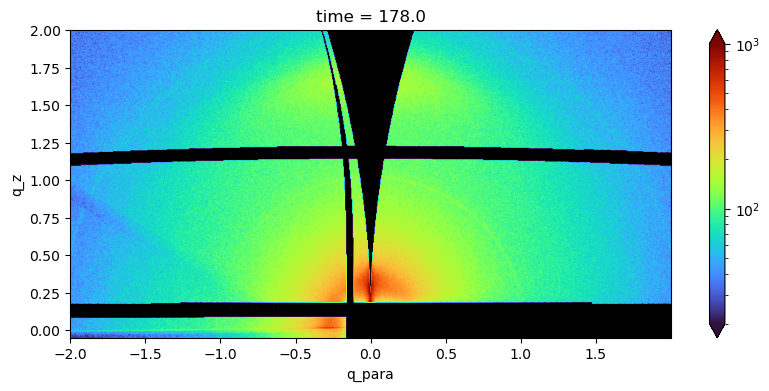

In [42]:
ax = recip_da_series.sel(time=178, q_z=slice(-0.05,2), q_para=slice(-2, 2)).plot.imshow(cmap=cmap, norm=LogNorm(2e1, 1e3), figsize=(10,4), interpolation='antialiased')
ax.axes.set_aspect('equal')

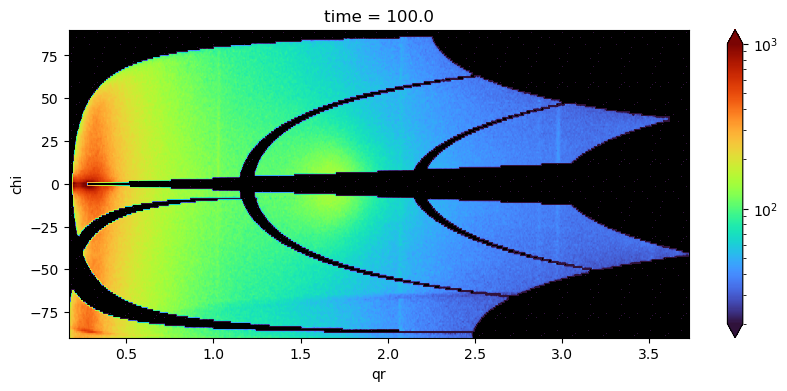

In [43]:
ax = caked_da_series.sel(time=100).plot.imshow(cmap=cmap, norm=LogNorm(2e1, 1e3), figsize=(10,4), interpolation='antialiased')
ax.axes.set_aspect('auto')